# Veg ET validation

In [1]:
import pandas as pd
from time import time
import xarray as xr
import numpy as np

In [2]:
def _get_year_month(product, tif):
    fn = tif.split('/')[-1]
    fn = fn.replace(product,'')
    fn = fn.replace('.tif','')
    fn = fn.replace('_','')
    print(fn)
    return fn

In [3]:
def _file_object(bucket_prefix,product_name,year,day):
    if product_name == 'NDVI':
        decade = str(year)[:3]+'0'
        variable_prefix = bucket_prefix + 'NDVI_FORE_SCE_MED/delaware_basin_FS_'
        file_object = variable_prefix  + str(decade) + '/' + 'FS_{0}_{1}_med_{2}.tif'.format(str(decade), product_name, day)
    elif product_name == 'ETo':
        decade = str(year)[:3]+'0'
        variable_prefix = bucket_prefix +'ETo_Moving_Average_byDOY/'
        file_object =  variable_prefix + '{0}_{1}/'.format(str(decade), str(int(decade)+10)) + '{0}_DOY{1}.tif'.format(product_name,day)
    elif product_name == 'Tasavg' or product_name == 'Tasmax' or product_name == 'Tasmin':
        variable_prefix = bucket_prefix + 'Temp/' + product_name + '/'
        file_object = variable_prefix  + str(year) + '/' + '{}_'.format(product_name) + str(year) + day + '.tif'
    elif product_name == 'PPT':
        variable_prefix = bucket_prefix + product_name + '/'
        file_object = variable_prefix  + str(year) + '/' + '{}_'.format(product_name) + str(year) + day + '.tif'
    else:
        file_object = bucket_prefix  + str(start_year) + '/' + f'{product_name}_' + str(start_year) + day + '.tif'
    return file_object

In [4]:
def create_s3_list_of_days_start_end(main_bucket_prefix, start_year,start_day, end_year, end_day, product_name):
    the_list = []
    years = []
    for year in (range(int(start_year),int(end_year)+1)):
        years.append(year)
    if len(years) == 1:
        for i in range(int(start_day),int(end_day)):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,start_year,day)
            the_list.append(file_object)
    elif len(years) == 2:
        for i in range(int(start_day),366):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,start_year,day)
            the_list.append(file_object)
        for i in range(1,int(end_day)):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,end_year,day)
            the_list.append(file_object)
    else:
        for i in range(int(start_day),366):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,start_year,day)
            the_list.append(file_object)
        for year in years[1:-1]:
            for i in range(1,366):
                day = f'{i:03d}'
                file_object = _file_object(main_bucket_prefix,product_name,year,day)
                the_list.append(file_object)
        for i in range(1,int(end_day)):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,end_year,day)
            the_list.append(file_object)
    return the_list

In [5]:
def xr_build_cube_concat_ds_one(tif_list, product, x, y):
    start = time()
    my_da_list =[]
    year_month_list = []
    for tif in tif_list:
        #tiffile = 's3://dev-et-data/' + tif
        tiffile = tif
        print(tiffile)
        da = xr.open_rasterio(tiffile)
        daSub = da.sel(x=x, y=y, method='nearest')
        #da = da.squeeze().drop(labels='band')
        #da.name=product
        my_da_list.append(daSub)
        tnow = time()
        elapsed = tnow - start
        print(tif, elapsed)
        year_month_list.append(_get_year_month(product, tif))

    da = xr.concat(my_da_list, dim='band')
    da = da.rename({'band':'year_month'})
    da = da.assign_coords(year_month=year_month_list)
    DS = da.to_dataset(name=product)
    return(DS)

In [6]:
main_bucket_prefix='s3://dev-et-data/in/DelawareRiverBasin/'
start_year = '1950'
start_day = '1'
end_year = '1950'
end_day = '11'
x=-75
y=41

## Step 1: Get pixel values for input variables

In [7]:
df_list=[]
for product in ['PPT','Tasavg', 'Tasmin', 'Tasmax', 'NDVI', 'ETo']:
    print("==="*30)
    print("processing product",product)
    tif_list = create_s3_list_of_days_start_end(main_bucket_prefix, start_year,start_day, end_year, end_day, product)
    print (tif_list)
    ds_pix=xr_build_cube_concat_ds_one(tif_list, product, x, y)
    my_index = ds_pix['year_month'].values
    my_array = ds_pix[product].values
    df = pd.DataFrame(my_array, columns=[product,], index=my_index)
    df_list.append(df)
    

processing product PPT
['s3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950001.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950002.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950003.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950004.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950005.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950006.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950007.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950008.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950009.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950010.tif']
s3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950001.tif
s3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950001.tif 0.5204815864562988
1950001
s3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950002.tif
s3://dev-et-data/in/DelawareRiverBasin/PPT/1950/PPT_1950002.tif 0.62583327293396
195000

s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950002.tif 0.2130575180053711
1950002
s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950003.tif
s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950003.tif 0.32180333137512207
1950003
s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950004.tif
s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950004.tif 0.43910861015319824
1950004
s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950005.tif
s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950005.tif 0.5305478572845459
1950005
s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950006.tif
s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950006.tif 0.7462649345397949
1950006
s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950007.tif
s3://dev-et-data/in/DelawareRiverBasin/Temp/Tasmax/1950/Tasmax_1950007.tif 0.8513598442077637
1950007
s3://dev-et

In [8]:
df_reset_list = []
for dframe in df_list:
    print (dframe)
    df_reset = dframe.set_index(df_list[0].index)
    print (df_reset)
    df_reset_list.append(df_reset)
df_veget = pd.concat(df_reset_list, axis=1)
df_veget['NDVI'] *= 0.0001
df_veget['Tasavg'] -= 273.15
df_veget['Tasmin'] -= 273.15
df_veget['Tasmax'] -= 273.15
df_veget

               PPT
1950001  22.103655
1950002  10.489694
1950003  12.496798
1950004   0.000000
1950005   0.000000
1950006   0.000000
1950007   0.000000
1950008   0.000000
1950009   2.937698
1950010   0.000000
               PPT
1950001  22.103655
1950002  10.489694
1950003  12.496798
1950004   0.000000
1950005   0.000000
1950006   0.000000
1950007   0.000000
1950008   0.000000
1950009   2.937698
1950010   0.000000
             Tasavg
1950001  279.295715
1950002  276.374756
1950003  281.106750
1950004  276.876587
1950005  274.469666
1950006  273.120117
1950007  272.331268
1950008  270.107239
1950009  268.194641
1950010  268.863678
             Tasavg
1950001  279.295715
1950002  276.374756
1950003  281.106750
1950004  276.876587
1950005  274.469666
1950006  273.120117
1950007  272.331268
1950008  270.107239
1950009  268.194641
1950010  268.863678
             Tasmin
1950001  274.587250
1950002  271.933441
1950003  276.610107
1950004  271.856262
1950005  270.783295
1950006  270.250427
19

,PPT,Tasavg,Tasmin,Tasmax,NDVI,ETo
1950001,22.103655,6.145721,1.437256,10.854187,0.4113,0.54
1950002,10.489694,3.224762,-1.216553,7.666107,0.4038,1.03
1950003,12.496798,7.956757,3.460114,12.453400,0.3970,0.83
1950004,0.000000,3.726593,-1.293732,8.746887,0.3909,1.03
1950005,0.000000,1.319672,-2.366699,5.006073,0.3855,0.89
1950006,0.000000,-0.029877,-2.899567,2.839813,0.3808,1.03
1950007,0.000000,-0.818726,-4.229889,2.592438,0.3766,0.96
1950008,0.000000,-3.042755,-6.305542,0.220001,0.3730,0.87
1950009,2.937698,-4.955353,-8.574249,-1.336456,0.3698,1.16
1950010,0.000000,-4.286316,-8.046204,-0.526428,0.3671,1.17


In [9]:
for static_product in ['awc', 'por', 'fc', 'intercept', 'water']:
    if static_product == 'awc' or static_product == 'por' or static_product == 'fc':
        file_object = ['s3://dev-et-data/in/NorthAmerica/Soil/' + '{}_NA_mosaic.tif'.format(static_product)]
    elif static_product == 'intercept':
        file_object = ['s3://dev-et-data/in/NorthAmerica/Soil/' + 'Intercept2016_nowater_int.tif']
    else:
        file_object = ['s3://dev-et-data/in/DelawareRiverBasin/' + 'DRB_water_mask_inland.tif']
    ds_pix=xr_build_cube_concat_ds_one(file_object, static_product, x, y)
    df_veget['{}'.format(static_product)] = ds_pix[static_product].values[0]
print (df_veget)


s3://dev-et-data/in/NorthAmerica/Soil/awc_NA_mosaic.tif
s3://dev-et-data/in/NorthAmerica/Soil/awc_NA_mosaic.tif 0.298691987991333
NAmosaic
s3://dev-et-data/in/NorthAmerica/Soil/por_NA_mosaic.tif
s3://dev-et-data/in/NorthAmerica/Soil/por_NA_mosaic.tif 0.32559943199157715
NAmosaic
s3://dev-et-data/in/NorthAmerica/Soil/fc_NA_mosaic.tif
s3://dev-et-data/in/NorthAmerica/Soil/fc_NA_mosaic.tif 0.3300642967224121
NAmosaic
s3://dev-et-data/in/NorthAmerica/Soil/Intercept2016_nowater_int.tif
s3://dev-et-data/in/NorthAmerica/Soil/Intercept2016_nowater_int.tif 0.34203124046325684
Intercept2016nowaterint
s3://dev-et-data/in/DelawareRiverBasin/DRB_water_mask_inland.tif
s3://dev-et-data/in/DelawareRiverBasin/DRB_water_mask_inland.tif 0.23814105987548828
DRBmaskinland
               PPT    Tasavg    Tasmin     Tasmax    NDVI   ETo    awc  \
1950001  22.103655  6.145721  1.437256  10.854187  0.4113  0.54  170.0   
1950002  10.489694  3.224762 -1.216553   7.666107  0.4038  1.03  170.0   
1950003  12.4967

In [10]:
df_veget

,PPT,Tasavg,Tasmin,Tasmax,NDVI,ETo,awc,por,fc,intercept,water
1950001,22.103655,6.145721,1.437256,10.854187,0.4113,0.54,170.0,437.73587,305.0,25,0
1950002,10.489694,3.224762,-1.216553,7.666107,0.4038,1.03,170.0,437.73587,305.0,25,0
1950003,12.496798,7.956757,3.460114,12.453400,0.3970,0.83,170.0,437.73587,305.0,25,0
1950004,0.000000,3.726593,-1.293732,8.746887,0.3909,1.03,170.0,437.73587,305.0,25,0
1950005,0.000000,1.319672,-2.366699,5.006073,0.3855,0.89,170.0,437.73587,305.0,25,0
1950006,0.000000,-0.029877,-2.899567,2.839813,0.3808,1.03,170.0,437.73587,305.0,25,0
1950007,0.000000,-0.818726,-4.229889,2.592438,0.3766,0.96,170.0,437.73587,305.0,25,0
1950008,0.000000,-3.042755,-6.305542,0.220001,0.3730,0.87,170.0,437.73587,305.0,25,0
1950009,2.937698,-4.955353,-8.574249,-1.336456,0.3698,1.16,170.0,437.73587,305.0,25,0
1950010,0.000000,-4.286316,-8.046204,-0.526428,0.3671,1.17,170.0,437.73587,305.0,25,0


## Step 2: Run Veg ET model for a selected pixel

In [11]:
pptcorr = 1
rf_value = 0.167
rf_low_thresh_temp = 0
rf_high_thresh_temp = 6
melt_factor = 0.06
dc_coeff: 0.65
rf_coeff = 0.35
k_factor = 1.25
ndvi_factor = 0.2
water_factor = 0.7
bias_corr = 0.85
alfa_factor = 1.25


df_veget['PPTcorr'] = df_veget['PPT']*pptcorr
df_veget['PPTeff'] = df_veget['PPTcorr']*(1-df_veget['intercept']/100)
df_veget['PPTinter'] = df_veget['PPTcorr']*(df_veget['intercept']/100)
df_veget['Tmin0'] = np.where(df_veget['Tasmin']<0,0,df_veget['Tasmin'])
df_veget['Tmax0'] = np.where(df_veget['Tasmax']<0,0,df_veget['Tasmax'])

rain_frac_conditions = [(df_veget['Tasavg']<=rf_low_thresh_temp),
                       (df_veget['Tasavg']>=rf_low_thresh_temp)&(df_veget['Tasavg']<=rf_high_thresh_temp),
                       (df_veget['Tasavg']>=rf_high_thresh_temp)]
rain_frac_values = [0,df_veget['Tasavg']*rf_value,1]
df_veget['rain_frac'] = np.select(rain_frac_conditions,rain_frac_values)

df_veget['melt_rate'] = melt_factor*(df_veget['Tmax0']**2 - df_veget['Tmax0']*df_veget['Tmin0'])
df_veget['snow_melt_rate'] = np.where(df_veget['Tasavg']<0,0,df_veget['melt_rate'])

df_veget['rain']=df_veget['PPTeff']*df_veget['rain_frac']


In [12]:
def _snow_water_equivalent(rain_frac, PPTeff):
    swe_value = (1-rain_frac)*PPTeff
    return swe_value

def _snow_melt(melt_rate,swe,snowpack):
    if melt_rate <= (swe + snowpack):
        snowmelt_value = melt_rate
    else:
        snowmelt_value = swe_value + snowpack
    return snowmelt_value

def _snow_pack(snowpack_prev,swe,snow_melt):
    if (snowpack_prev +  swe - snow_melt) < 0:
        SNOW_pack_value = 0
    else:
        SNOW_pack_value = snowpack_prev +  swe - snow_melt
    return SNOW_pack_value
        
def _runoff(snow_melt,awc,swi):
    if snow_melt<awc:
        rf_value = 0
    else:
        rf_value = swi-awc
    return rf_value

def _surface_runoff(rf, por,fc,rf_coeff):
    if rf <= por - fc:
        srf_value  = rf*rf_coeff
    else:
        srf_value = (rf - (por - fc)) + rf_coeff*(por - fc)
    return srf_value

def _etasw_calc(k_factor, ndvi, ndvi_factor, eto, bias_corr, swi, awc, water, water_factor, alfa_factor):
    etasw1A_value = (k_factor*ndvi+ndvi_factor)*eto*bias_corr
    etasw1B_value = (k_factor*ndvi)*eto*bias_corr
    if ndvi > 0.4:
        etasw1_value = etasw1A_value
    else:
        etasw1_value = etasw1B_value
    etasw2_value = swi/(0.5*awc)*etasw1_value
    if swi>0.5*awc:
        etasw3_value = etasw1_value
    else:
        etasw3_value = etasw2_value
    if etasw3_value>swi:
        etasw4_value = swi
    else:
        etasw4_value = etasw3_value
    if etasw4_value> awc:
        etasw5_value = awc
    else:
        etasw5_value = etasw4_value
    etc_value = etasw1A_value
    if water == 0:
        etasw_value = etasw5_value
    else:
        etasw_value = water_factor*alfa_factor*bias_corr*eto
    if (etc_value - etasw_value)<0:
        netet_value = 0
    else:
        netet_value = etc_value - etasw_value
    return [etasw1A_value, etasw1B_value, etasw1_value, etasw2_value, etasw3_value, etasw4_value, etasw5_value, etasw_value, etc_value, netet_value]

def _soil_water_final(swi,awc,etasw5):
    if swi> awc:
        swf_value = awc - etasw5
    elif (swi> awc) & (swi-etasw5<0):
        swf_value = 0
    else:
        swf_value = swi-etasw5
    return swf_value

In [13]:
swe_list = []
snowmelt_list = []
snwpk_list = []
swi_list = []
rf_list = []
srf_list = []
dd_list = []
etasw1A_list = []
etasw1B_list = []
etasw1_list = []
etasw2_list = []
etasw3_list = []
etasw4_list = []
etasw5_list = []
etasw_list = []
etc_list = []
netet_list = []
swf_list = []

for index, row in df_veget.iterrows():
    if index == df_veget.index[0]:
        swe_value = 0
        swe_list.append(swe_value)
        snowmelt_value = swe_value
        snowmelt_list.append(snowmelt_value)
        snwpk_value = 0
        snwpk_list.append(snwpk_value)
        swi_value = 0.5*row['awc']+ row['PPTeff'] + snowmelt_value
        swi_list.append(swi_value)
        rf_value = _runoff(snowmelt_value,row['awc'],swi_value)
        rf_list.append(rf_value)
        srf_value = _surface_runoff(rf_value, row['por'],row['fc'],rf_coeff)
        srf_list.append(srf_value)
        dd_value = rf_value - srf_value
        dd_list.append(dd_value)
        eta_variables = _etasw_calc(k_factor, row['NDVI'], ndvi_factor, row['ETo'], bias_corr, swi_value, row['awc'], row['water'], water_factor, alfa_factor)
        etasw1A_list.append(eta_variables[0])
        etasw1B_list.append(eta_variables[1])
        etasw1_list.append(eta_variables[2])
        etasw2_list.append(eta_variables[3])
        etasw3_list.append(eta_variables[4])
        etasw4_list.append(eta_variables[5])
        etasw5_list.append(eta_variables[6])
        etasw_list.append(eta_variables[7])
        etc_list.append(eta_variables[8])
        netet_list.append(eta_variables[9])
        swf_value = _soil_water_final(swi_value,row['awc'],eta_variables[7])
        swf_list.append(swf_value)   
    else:
        swe_value = _snow_water_equivalent(row['rain_frac'],row['PPTeff'])
        swe_list.append(swe_value)
        snowmelt_value = _snow_melt(row['melt_rate'],swe_value,snwpk_list[-1])
        snowmelt_list.append(snowmelt_value)
        snwpk_value = _snow_pack(snwpk_list[-1],swe_value,snowmelt_value)
        snwpk_list.append(snwpk_value)
        swi_value = swf_list[-1] + row['rain'] + snowmelt_value
        swi_list.append(swi_value)
        rf_value = _runoff(snowmelt_value,row['awc'],swi_value)
        rf_list.append(rf_value)
        srf_value = _surface_runoff(rf_value, row['por'],row['fc'],rf_coeff)
        srf_list.append(srf_value)
        dd_value = rf_value - srf_value
        dd_list.append(dd_value)
        eta_variables = _etasw_calc(k_factor, row['NDVI'], ndvi_factor, row['ETo'], bias_corr, swi_value, row['awc'], row['water'], water_factor, alfa_factor)
        etasw1A_list.append(eta_variables[0])
        etasw1B_list.append(eta_variables[1])
        etasw1_list.append(eta_variables[2])
        etasw2_list.append(eta_variables[3])
        etasw3_list.append(eta_variables[4])
        etasw4_list.append(eta_variables[5])
        etasw5_list.append(eta_variables[6])
        etasw_list.append(eta_variables[7])
        etc_list.append(eta_variables[8])
        netet_list.append(eta_variables[9])
        swf_value = _soil_water_final(swi_value,row['awc'],eta_variables[7])
        swf_list.append(swf_value)
        
df_veget['swe'] = swe_list      
df_veget['snowmelt'] = snowmelt_list 
df_veget['snwpk'] = snwpk_list
df_veget['swi'] = swi_list
df_veget['rf'] = rf_list
df_veget['srf'] = srf_list
df_veget['dd'] = dd_list
df_veget['etasw1A'] = etasw1A_list
df_veget['etasw1B'] = etasw1B_list
df_veget['etasw1'] = etasw1_list
df_veget['etasw2'] = etasw2_list
df_veget['etasw3'] = etasw3_list
df_veget['etasw4'] = etasw4_list
df_veget['etasw5'] = etasw5_list
df_veget['etasw'] = etasw_list
df_veget['etc'] = etc_list
df_veget['netet'] = netet_list
df_veget['swf'] = swf_list

In [14]:
pd.set_option('display.max_columns', None)
df_veget

,PPT,Tasavg,Tasmin,Tasmax,NDVI,ETo,awc,por,fc,intercept,water,PPTcorr,PPTeff,PPTinter,Tmin0,Tmax0,rain_frac,melt_rate,snow_melt_rate,rain,swe,snowmelt,snwpk,swi,rf,srf,dd,etasw1A,etasw1B,etasw1,etasw2,etasw3,etasw4,etasw5,etasw,etc,netet,swf
1950001,22.103655,6.145721,1.437256,10.854187,0.4113,0.54,170.0,437.73587,305.0,25,0,22.103655,16.577741,5.525914,1.437256,10.854187,1.000000,6.132788,6.132788,16.577741,0.000000,0.000000,0.000000,101.577741,0,0.0,0.0,0.327783,0.235983,0.327783,0.391712,0.327783,0.327783,0.327783,0.327783,0.327783,0.0000,101.249958
1950002,10.489694,3.224762,-1.216553,7.666107,0.4038,1.03,170.0,437.73587,305.0,25,0,10.489694,7.867270,2.622423,0.000000,7.666107,0.538535,3.526152,3.526152,4.236802,3.630468,3.526152,0.104316,109.012912,0,0.0,0.0,0.617009,0.441909,0.617009,0.791317,0.617009,0.617009,0.617009,0.617009,0.617009,0.0000,108.395903
1950003,12.496798,7.956757,3.460114,12.453400,0.3970,0.83,170.0,437.73587,305.0,25,0,12.496798,9.372598,3.124199,3.460114,12.453400,1.000000,6.719819,6.719819,9.372598,0.000000,0.104316,0.000000,117.872818,0,0.0,0.0,0.491204,0.350104,0.350104,0.485503,0.350104,0.350104,0.350104,0.350104,0.491204,0.1411,117.522713
1950004,0.000000,3.726593,-1.293732,8.746887,0.3909,1.03,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,8.746887,0.622341,4.590482,4.590482,0.000000,0.000000,0.000000,0.000000,117.522713,0,0.0,0.0,0.602891,0.427791,0.427791,0.591473,0.427791,0.427791,0.427791,0.427791,0.602891,0.1751,117.094922
1950005,0.000000,1.319672,-2.366699,5.006073,0.3855,0.89,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,5.006073,0.220385,1.503646,1.503646,0.000000,0.000000,0.000000,0.000000,117.094922,0,0.0,0.0,0.515838,0.364538,0.364538,0.502184,0.364538,0.364538,0.364538,0.364538,0.515838,0.1513,116.730384
1950006,0.000000,-0.029877,-2.899567,2.839813,0.3808,1.03,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,2.839813,0.000000,0.483872,0.000000,0.000000,0.000000,0.000000,0.000000,116.730384,0,0.0,0.0,0.591838,0.416738,0.416738,0.572306,0.416738,0.416738,0.416738,0.416738,0.591838,0.1751,116.313646
1950007,0.000000,-0.818726,-4.229889,2.592438,0.3766,0.96,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,2.592438,0.000000,0.403244,0.000000,0.000000,0.000000,0.000000,0.000000,116.313646,0,0.0,0.0,0.547332,0.384132,0.384132,0.525645,0.384132,0.384132,0.384132,0.384132,0.547332,0.1632,115.929514
1950008,0.000000,-3.042755,-6.305542,0.220001,0.3730,0.87,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,0.220001,0.000000,0.002904,0.000000,0.000000,0.000000,0.000000,0.000000,115.929514,0,0.0,0.0,0.492692,0.344792,0.344792,0.470254,0.344792,0.344792,0.344792,0.344792,0.492692,0.1479,115.584722
1950009,2.937698,-4.955353,-8.574249,-1.336456,0.3698,1.16,170.0,437.73587,305.0,25,0,2.937698,2.203274,0.734425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.203274,0.000000,2.203274,115.584722,0,0.0,0.0,0.652978,0.455778,0.455778,0.619777,0.455778,0.455778,0.455778,0.455778,0.652978,0.1972,115.128943
1950010,0.000000,-4.286316,-8.046204,-0.526428,0.3671,1.17,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.203274,115.128943,0,0.0,0.0,0.655251,0.456351,0.456351,0.618109,0.456351,0.456351,0.456351,0.456351,0.655251,0.1989,114.672592


## Step 3: Sample output data computed in the cloud

In [15]:
output_bucket_prefix='s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/'

In [16]:
df_list_cloud=[]

products=['rain', 'swe', 'snowmelt', 'snwpk','srf', 'dd', 'etasw5', 'etasw', 'netet', 'swf', 'etc']
#products=['srf', 'dd', 'etasw', 'netet', 'etc']

for product_out in products:
    print("==="*30)
    print("processing product",product_out)
    tif_list = create_s3_list_of_days_start_end(output_bucket_prefix, start_year,start_day, end_year, end_day, product_out)
    ds_pix=xr_build_cube_concat_ds_one(tif_list, product_out, x, y)
    
    my_index = ds_pix['year_month'].values
    my_array = ds_pix[product_out].values
    df = pd.DataFrame(my_array, columns=['{}_cloud'.format(product_out),], index=my_index)
    df_list_cloud.append(df)

processing product rain
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/rain_1950001.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/rain_1950001.tif 0.6380391120910645
1950001
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/rain_1950002.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/rain_1950002.tif 1.236025094985962
1950002
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/rain_1950003.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/rain_1950003.tif 1.8442468643188477
1950003
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/rain_1950004.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/rain_1950004.tif 2.5064282417297363
1950004
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/rain_1950005.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/rain_1950005.tif 3.1117775440216064
1950005
s3://dev-et-data/enduser/Delawar

s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/srf_1950001.tif 0.6749377250671387
1950001
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/srf_1950002.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/srf_1950002.tif 1.3177778720855713
1950002
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/srf_1950003.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/srf_1950003.tif 1.9504945278167725
1950003
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/srf_1950004.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/srf_1950004.tif 2.5580685138702393
1950004
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/srf_1950005.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/srf_1950005.tif 3.2353060245513916
1950005
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/srf_1950006.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/s

s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/netet_1950002.tif 1.3375446796417236
1950002
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/netet_1950003.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/netet_1950003.tif 1.9800586700439453
1950003
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/netet_1950004.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/netet_1950004.tif 2.608567714691162
1950004
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/netet_1950005.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/netet_1950005.tif 3.256239652633667
1950005
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/netet_1950006.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/netet_1950006.tif 4.128407955169678
1950006
s3://dev-et-data/enduser/DelawareRiverBasin/olena_test_5yr/1950/netet_1950007.tif
s3://dev-et-data/enduser/DelawareRiverBasin/olen

In [17]:
for dframe in df_list_cloud:
    print(dframe)

         rain_cloud
1950001   19.407009
1950002    4.959883
1950003   10.972188
1950004    0.000000
1950005    0.000000
1950006    0.000000
1950007    0.000000
1950008    0.000000
1950009    0.000000
1950010    0.000000
         swe_cloud
1950001   0.000000
1950002   4.250068
1950003   0.000000
1950004   0.000000
1950005   0.000000
1950006   0.000000
1950007   0.000000
1950008   0.000000
1950009   2.579299
1950010   0.000000
         snowmelt_cloud
1950001        0.000000
1950002        2.993192
1950003        1.256876
1950004        0.000000
1950005        0.000000
1950006        0.000000
1950007       -0.006096
1950008       -0.388629
1950009       -0.327101
1950010       -0.434559
         snwpk_cloud
1950001     0.000000
1950002     1.256876
1950003     0.000000
1950004     0.000000
1950005     0.000000
1950006     0.000000
1950007     0.006096
1950008     0.394724
1950009     3.301124
1950010     3.735683
         srf_cloud
1950001        0.0
1950002        0.0
1950003        0.0


In [18]:
df_veget_cloud = pd.concat(df_list_cloud, axis=1)

In [19]:
df_veget_cloud

,rain_cloud,swe_cloud,snowmelt_cloud,snwpk_cloud,srf_cloud,dd_cloud,etasw5_cloud,etasw_cloud,netet_cloud,swf_cloud,etc_cloud
1950001,19.407009,0.000000,0.000000,0.000000,0.0,0.0,0.327783,0.327783,0.0000,104.079225,0.327783
1950002,4.959883,4.250068,2.993192,1.256876,0.0,0.0,0.617009,0.617009,0.0000,111.415292,0.617009
1950003,10.972188,0.000000,1.256876,0.000000,0.0,0.0,0.350104,0.350104,0.1411,123.294251,0.491204
1950004,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.427791,0.427791,0.1751,122.866460,0.602891
1950005,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.364538,0.364538,0.1513,122.501922,0.515838
1950006,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.416738,0.416738,0.1751,122.085184,0.591838
1950007,0.000000,0.000000,-0.006096,0.006096,0.0,0.0,0.384132,0.384132,0.1632,121.694956,0.547332
1950008,0.000000,0.000000,-0.388629,0.394724,0.0,0.0,0.344792,0.344792,0.1479,120.961536,0.492692
1950009,0.000000,2.579299,-0.327101,3.301124,0.0,0.0,0.455779,0.455779,0.1972,120.178657,0.652979
1950010,0.000000,0.000000,-0.434559,3.735683,0.0,0.0,0.456351,0.456351,0.1989,119.287747,0.655251


In [20]:
df_validation =  pd.concat([df_veget,df_veget_cloud], axis=1)
df_validation

,PPT,Tasavg,Tasmin,Tasmax,NDVI,ETo,awc,por,fc,intercept,water,PPTcorr,PPTeff,PPTinter,Tmin0,Tmax0,rain_frac,melt_rate,snow_melt_rate,rain,swe,snowmelt,snwpk,swi,rf,srf,dd,etasw1A,etasw1B,etasw1,etasw2,etasw3,etasw4,etasw5,etasw,etc,netet,swf,rain_cloud,swe_cloud,snowmelt_cloud,snwpk_cloud,srf_cloud,dd_cloud,etasw5_cloud,etasw_cloud,netet_cloud,swf_cloud,etc_cloud
1950001,22.103655,6.145721,1.437256,10.854187,0.4113,0.54,170.0,437.73587,305.0,25,0,22.103655,16.577741,5.525914,1.437256,10.854187,1.000000,6.132788,6.132788,16.577741,0.000000,0.000000,0.000000,101.577741,0,0.0,0.0,0.327783,0.235983,0.327783,0.391712,0.327783,0.327783,0.327783,0.327783,0.327783,0.0000,101.249958,19.407009,0.000000,0.000000,0.000000,0.0,0.0,0.327783,0.327783,0.0000,104.079225,0.327783
1950002,10.489694,3.224762,-1.216553,7.666107,0.4038,1.03,170.0,437.73587,305.0,25,0,10.489694,7.867270,2.622423,0.000000,7.666107,0.538535,3.526152,3.526152,4.236802,3.630468,3.526152,0.104316,109.012912,0,0.0,0.0,0.617009,0.441909,0.617009,0.791317,0.617009,0.617009,0.617009,0.617009,0.617009,0.0000,108.395903,4.959883,4.250068,2.993192,1.256876,0.0,0.0,0.617009,0.617009,0.0000,111.415292,0.617009
1950003,12.496798,7.956757,3.460114,12.453400,0.3970,0.83,170.0,437.73587,305.0,25,0,12.496798,9.372598,3.124199,3.460114,12.453400,1.000000,6.719819,6.719819,9.372598,0.000000,0.104316,0.000000,117.872818,0,0.0,0.0,0.491204,0.350104,0.350104,0.485503,0.350104,0.350104,0.350104,0.350104,0.491204,0.1411,117.522713,10.972188,0.000000,1.256876,0.000000,0.0,0.0,0.350104,0.350104,0.1411,123.294251,0.491204
1950004,0.000000,3.726593,-1.293732,8.746887,0.3909,1.03,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,8.746887,0.622341,4.590482,4.590482,0.000000,0.000000,0.000000,0.000000,117.522713,0,0.0,0.0,0.602891,0.427791,0.427791,0.591473,0.427791,0.427791,0.427791,0.427791,0.602891,0.1751,117.094922,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.427791,0.427791,0.1751,122.866460,0.602891
1950005,0.000000,1.319672,-2.366699,5.006073,0.3855,0.89,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,5.006073,0.220385,1.503646,1.503646,0.000000,0.000000,0.000000,0.000000,117.094922,0,0.0,0.0,0.515838,0.364538,0.364538,0.502184,0.364538,0.364538,0.364538,0.364538,0.515838,0.1513,116.730384,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.364538,0.364538,0.1513,122.501922,0.515838
1950006,0.000000,-0.029877,-2.899567,2.839813,0.3808,1.03,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,2.839813,0.000000,0.483872,0.000000,0.000000,0.000000,0.000000,0.000000,116.730384,0,0.0,0.0,0.591838,0.416738,0.416738,0.572306,0.416738,0.416738,0.416738,0.416738,0.591838,0.1751,116.313646,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.416738,0.416738,0.1751,122.085184,0.591838
1950007,0.000000,-0.818726,-4.229889,2.592438,0.3766,0.96,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,2.592438,0.000000,0.403244,0.000000,0.000000,0.000000,0.000000,0.000000,116.313646,0,0.0,0.0,0.547332,0.384132,0.384132,0.525645,0.384132,0.384132,0.384132,0.384132,0.547332,0.1632,115.929514,0.000000,0.000000,-0.006096,0.006096,0.0,0.0,0.384132,0.384132,0.1632,121.694956,0.547332
1950008,0.000000,-3.042755,-6.305542,0.220001,0.3730,0.87,170.0,437.73587,305.0,25,0,0.000000,0.000000,0.000000,0.000000,0.220001,0.000000,0.002904,0.000000,0.000000,0.000000,0.000000,0.000000,115.929514,0,0.0,0.0,0.492692,0.344792,0.344792,0.470254,0.344792,0.344792,0.344792,0.344792,0.492692,0.1479,115.584722,0.000000,0.000000,-0.388629,0.394724,0.0,0.0,0.344792,0.344792,0.1479,120.961536,0.492692
1950009,2.937698,-4.955353,-8.574249,-1.336456,0.3698,1.16,170.0,437.73587,305.0,25,0,2.937698,2.203274,0.734425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.203274,0.000000,2.203274,115.584722,0,0.0,0.0,0.652978,0.455778,0.455778,0.619777,0.455778,0.455778,0.455778,0.455778,0.652978,0.1972,115.128943,0.000000,2.579299,-0.327101,3.301124,0.0,0.0,0.455779,0.455779,0.1972,120.178657,0.652979
19500

## Step 4: Visualization of validation results

### Import Visualization libraries

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy import stats
import matplotlib.patches as mpatches

### Visualize Veg ET input variables

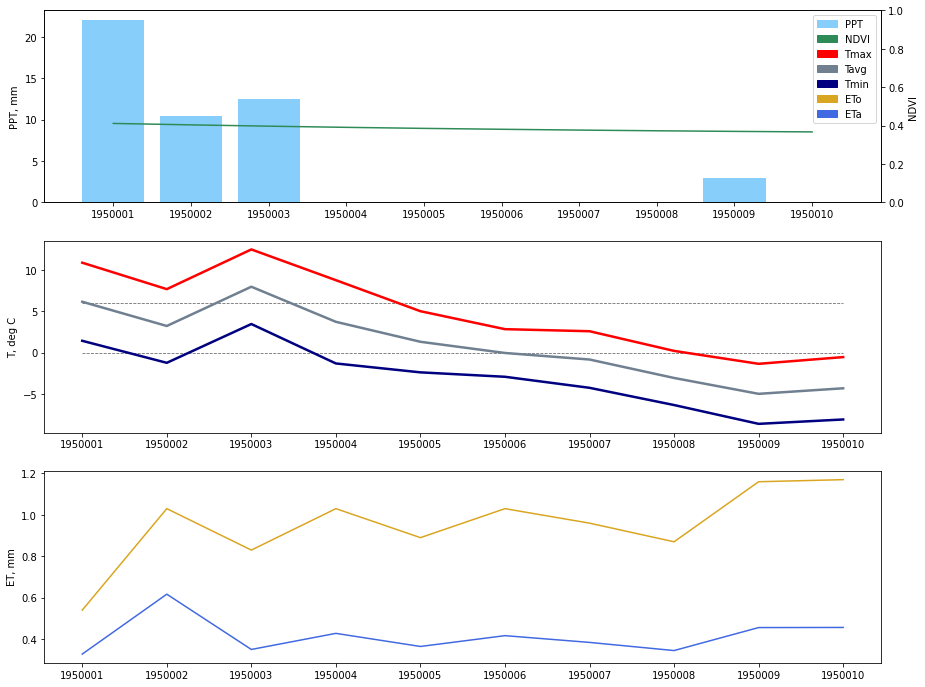

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(15,12))

#ax = fig.add_subplot()
axs[0].bar(df_validation.index, df_validation["PPT"], color = 'lightskyblue')
#axs[0].plot(df_validation.index, df_validation["PPT"], color = 'lightskyblue')

ax0 = axs[0].twinx()
ax0.plot(df_validation.index, df_validation["NDVI"], color = 'seagreen')
axs[0].set_ylabel("PPT, mm")
ax0.set_ylabel("NDVI")
ax0.set_ylim([0,1])

low_threshold = np.array([0 for i in range(len(df_validation))])
axs[1].plot(df_validation.index, low_threshold,  '--', color = 'dimgray', linewidth=0.8)
high_threshold = np.array([6 for i in range(len(df_validation))])
axs[1].plot(df_validation.index, high_threshold,  '--', color = 'dimgray', linewidth=0.8)
axs[1].plot(df_validation.index, df_validation["Tasmin"], color = 'navy', linewidth=2.5)
axs[1].plot(df_validation.index, df_validation["Tasavg"], color = 'slategray', linewidth=2.5)
axs[1].plot(df_validation.index, df_validation["Tasmax"], color = 'red', linewidth=2.5)
axs[1].set_ylabel("T, deg C")


axs[2].plot(df_validation.index, df_validation["ETo"], color = 'goldenrod')
axs[2].plot(df_validation.index, df_validation["etasw"], color = 'royalblue')
axs[2].set_ylabel("ET, mm")

ppt = mpatches.Patch(color='lightskyblue', label='PPT')
ndvi = mpatches.Patch(color='seagreen', label='NDVI')
tmax = mpatches.Patch(color='red', label='Tmax')
tavg = mpatches.Patch(color='slategray', label='Tavg')
tmin = mpatches.Patch(color='navy', label='Tmin')
eto = mpatches.Patch(color='goldenrod', label='ETo')
eta = mpatches.Patch(color='royalblue', label='ETa')
plt.legend(handles=[ppt, ndvi, tmax, tavg, tmin, eto,eta])


### Compare Veg ET output variables computed with data frames vs output variables computed in the cloud

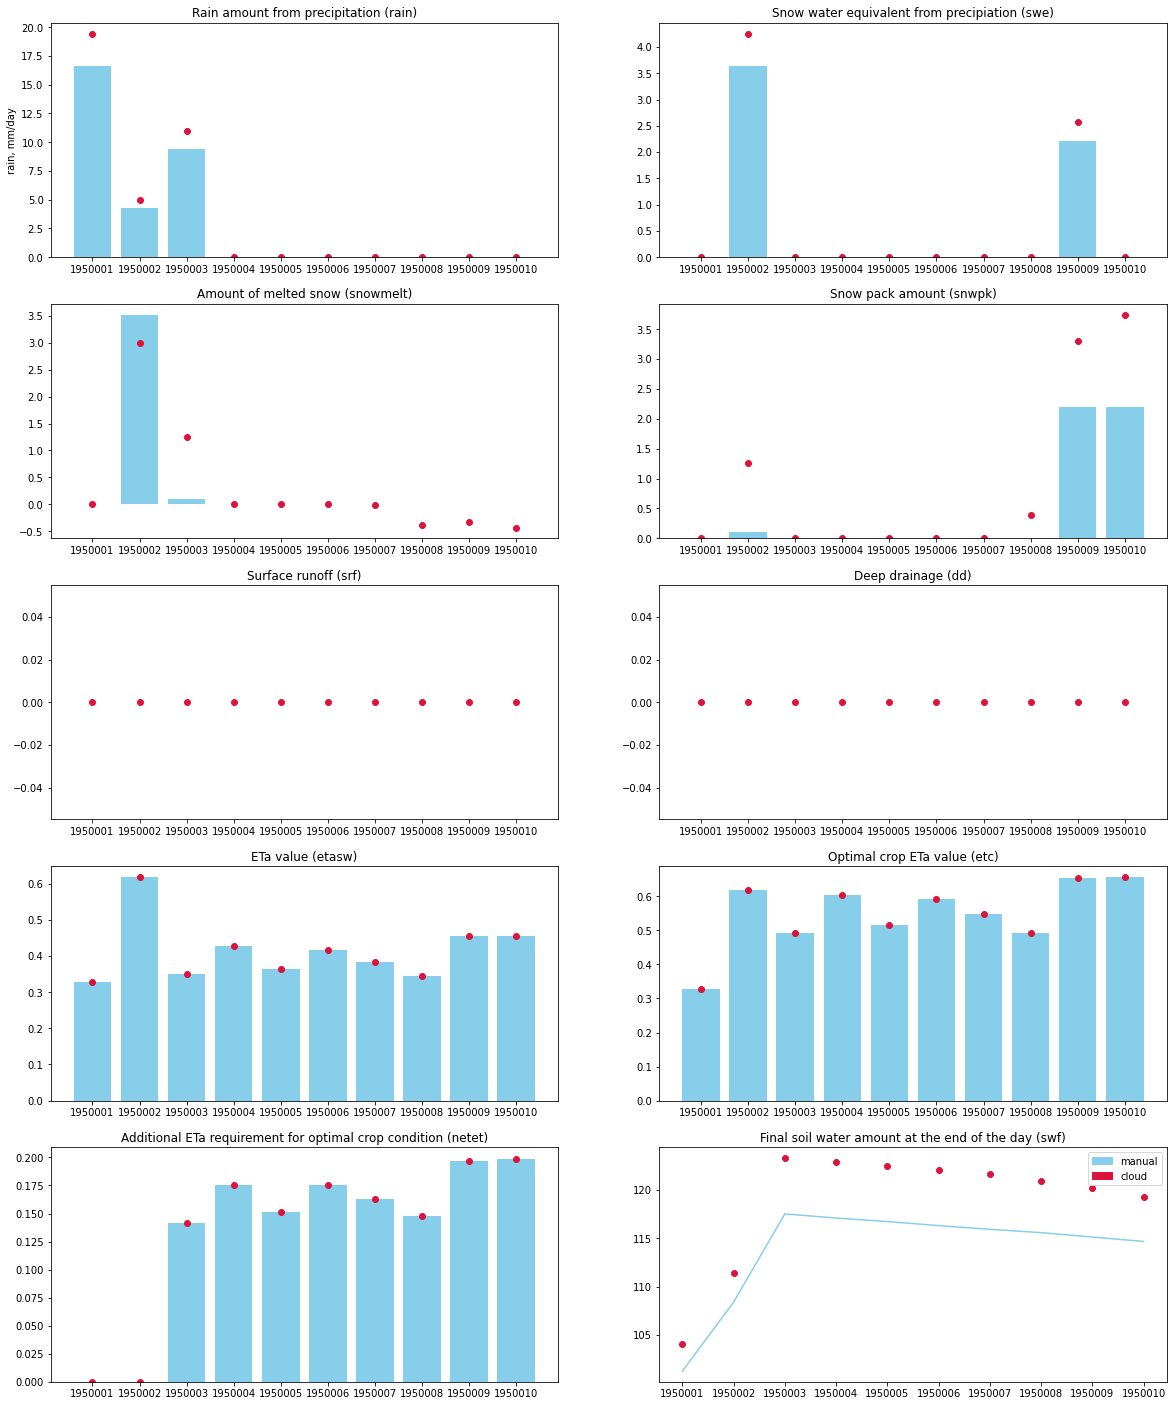

In [23]:
fig, axs = plt.subplots(5, 2, figsize=(20,25))


axs[0, 0].bar(df_validation.index, df_validation["rain"], color = 'skyblue')
axs[0, 0].plot(df_validation.index, df_validation["rain_cloud"], 'ro', color = 'crimson')
axs[0, 0].set_title("Rain amount from precipitation (rain)")
axs[0, 0].set_ylabel("rain, mm/day")


axs[0, 1].bar(df_validation.index, df_validation["swe"], color = 'skyblue')
axs[0, 1].plot(df_validation.index, df_validation["swe_cloud"], 'ro', color = 'crimson')
axs[0, 1].set_title("Snow water equivalent from precipiation (swe)")


axs[1, 0].bar(df_validation.index, df_validation["snowmelt"], color = 'skyblue')
axs[1, 0].plot(df_validation.index, df_validation["snowmelt_cloud"], 'ro', color = 'crimson')
axs[1, 0].set_title("Amount of melted snow (snowmelt)")


axs[1, 1].bar(df_validation.index, df_validation["snwpk"], color = 'skyblue')
axs[1, 1].plot(df_validation.index, df_validation["snwpk_cloud"], 'ro', color = 'crimson')
axs[1, 1].set_title("Snow pack amount (snwpk)")


axs[2, 0].bar(df_validation.index, df_validation["srf"], color = 'skyblue')
axs[2, 0].plot(df_validation.index, df_validation["srf_cloud"], 'ro', color = 'crimson')
axs[2, 0].set_title("Surface runoff (srf)")

axs[2, 1].bar(df_validation.index, df_validation["dd"], color = 'skyblue')
axs[2, 1].plot(df_validation.index, df_validation["dd_cloud"], 'ro', color = 'crimson')
axs[2, 1].set_title("Deep drainage (dd)")


axs[3, 0].bar(df_validation.index, df_validation["etasw"], color = 'skyblue')
axs[3, 0].plot(df_validation.index, df_validation["etasw_cloud"], 'ro', color = 'crimson')
axs[3, 0].set_title("ETa value (etasw)")



axs[3, 1].bar(df_validation.index, df_validation["etc"], color = 'skyblue')
axs[3, 1].plot(df_validation.index, df_validation["etc_cloud"], 'ro', color = 'crimson')
axs[3, 1].set_title("Optimal crop ETa value (etc)")



axs[4, 0].bar(df_validation.index, df_validation["netet"], color = 'skyblue')
axs[4, 0].plot(df_validation.index, df_validation["netet_cloud"], 'ro', color = 'crimson')
axs[4, 0].set_title("Additional ETa requirement for optimal crop condition (netet)")


axs[4, 1].plot(df_validation.index, df_validation["swf"], color = 'skyblue')
axs[4, 1].plot(df_validation.index, df_validation["swf_cloud"], 'ro', color = 'crimson')
axs[4, 1].set_title("Final soil water amount at the end of the day (swf)")

manual = mpatches.Patch(color='skyblue', label='manual')
cloud = mpatches.Patch(color='crimson', label='cloud')
plt.legend(handles=[manual,cloud])